In [1]:
import pandas as pd

import numpy as np

from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier as dt
from datetime import datetime,timedelta
from sklearn.model_selection import train_test_split

from sklearn.metrics import accuracy_score

from sklearn.metrics import classification_report

from sklearn.metrics import confusion_matrix

from sklearn.model_selection import cross_val_score

import plotly.express as px

from matplotlib import pyplot as plt

from sklearn.ensemble import AdaBoostClassifier

import pandas_ta as pa

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestRegressor, VotingClassifier

from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import GaussianNB


In [50]:
df = pd.read_excel(r'S:\Risk\Risk Research\AI and Machine Learning\Final_Strategy\USDCHF\USDCHF_Data_2003.xlsx',sheet_name='Data',parse_dates=['Date'],index_col='Date')

#Calculate all the spreads
df['CHF2YSpread']=df['US2Y']-df['CHF2Y']
df['USCHFCurvesSpread']=df['US2Y10Y']-df['CHF2Y10Y']


df=df.drop(['US2Y','CHF2Y','US2Y10Y','CHF2Y10Y','VIX'], axis=1)

# Select the columns for which you want to apply pct_change()
columns_pct_change = ['USDCHF','MXUS','MXCH']

df_pct_change = df[columns_pct_change].pct_change()

df_pct_change['USCN-EQ-SPREAD']=df_pct_change['MXUS']-df_pct_change['MXCH']
df_pct_change.drop(['MXUS','MXCH'],axis=1,inplace=True)

#Calculate the difference for the remaining columns
df_diff = df.drop(columns_pct_change, axis=1).diff()

#Combine the 2 Datasets
df_combined = pd.concat([df_pct_change, df_diff], axis=1).dropna()

df_combined['MA4'] = df_combined['USDCHF'].rolling(window=4).mean()

df_combined['MA40'] = df_combined['USDCHF'].rolling(window=40).mean()

df_combined['MACross'] = np.NaN  # Initialize the signal column with zeros
df_combined.loc[df_combined['MA4'] > df_combined['MA40'], 'MACross'] = 1  # Set signal as 1 where MA4 > MA40
df_combined.loc[df_combined['MA4'] < df_combined['MA40'], 'MACross'] = -1

df_combined.drop(['MA4','MA40'],axis=1,inplace=True)

df_combined=df_combined.dropna(subset=['MACross'])

df_combined = df_combined[df_combined.index >="2009-01-01"]

df_combined

,USDCHF,USCN-EQ-SPREAD,CHFV1M,USDCHF25R1M,ECOSPREAD,CHF2YSpread,USCHFCurvesSpread,MACross
Date,,,,,,,,
2009-01-02,0.010561,0.043424,3.7050,0.3175,-23.0,0.0265,20.107,-1.0
2009-01-09,0.030334,-0.071778,-2.9075,0.4750,23.1,-0.3067,18.024,-1.0
2009-01-16,0.005026,0.002155,-3.1950,-0.0025,12.2,0.0563,-5.307,1.0
2009-01-23,0.030812,0.002139,-0.0625,0.4225,1.2,0.1495,10.988,1.0
2009-01-30,0.006671,-0.006742,-0.8550,-0.1200,90.0,0.1928,6.671,1.0
...,...,...,...,...,...,...,...,...
2023-11-10,0.004339,0.015334,-0.0700,0.0250,-5.2,0.1747,-7.535,1.0
2023-11-17,-0.018832,0.005376,-0.0500,-0.0125,-6.2,-0.1458,4.345,-1.0
2023-11-24,-0.003048,-0.000547,-0.1900,0.0275,-1.0,-0.0051,0.722,-1.0


In [58]:
df

,USDCHF,CHFV1M,USDCHF25R1M,ECOSPREAD,MXUS,MXCH,CHF2YSpread,USCHFCurvesSpread
Date,,,,,,,,
2007-03-02,1.2165,7.0009,-0.1980,14.9,1312.14,1152.65,2.1322,-24.852
2007-03-09,1.2347,6.8000,-0.0750,20.9,1326.48,1170.73,2.2311,-33.799
2007-03-16,1.2070,7.2500,-0.0750,14.8,1311.85,1142.55,2.1656,-26.736
2007-03-23,1.2192,6.9509,-0.4455,-6.9,1358.36,1190.99,2.1328,-22.037
2007-03-30,1.2156,6.8750,-0.4500,-16.8,1343.99,1176.39,2.1174,-25.704
...,...,...,...,...,...,...,...,...
2023-11-10,0.9027,6.2250,-0.1375,72.9,4198.58,1367.06,3.6933,-8.692
2023-11-17,0.8857,6.1750,-0.1500,66.7,4295.72,1391.34,3.5475,-4.347
2023-11-24,0.8830,5.9850,-0.1225,65.7,4339.65,1406.33,3.5424,-3.625


In [51]:
# Classification

def replace_values(val):
    if val > 0:
        return 1
    elif val < 0:
        return -1
    else:
        return 0

# Apply the function to each element in the DataFrame
df_binary = df_combined.applymap(replace_values)

df_binary


,USDCHF,USCN-EQ-SPREAD,CHFV1M,USDCHF25R1M,ECOSPREAD,CHF2YSpread,USCHFCurvesSpread,MACross
Date,,,,,,,,
2009-01-02,1,1,1,1,-1,1,1,-1
2009-01-09,1,-1,-1,1,1,-1,1,-1
2009-01-16,1,1,-1,-1,1,1,-1,1
2009-01-23,1,1,-1,1,1,1,1,1
2009-01-30,1,-1,-1,-1,1,1,1,1
...,...,...,...,...,...,...,...,...
2023-11-10,1,1,-1,1,-1,1,-1,1
2023-11-17,-1,1,-1,-1,-1,-1,1,-1
2023-11-24,-1,-1,-1,1,-1,-1,1,-1


In [52]:
#adding some comments here as well,can git finds it out

x=df_binary.drop(columns=['USDCHF']).shift(1).dropna()

y=df_binary['USDCHF'][1:]

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.4, shuffle=False,random_state=42)

model = DecisionTreeClassifier(criterion='gini',max_depth=4, random_state=0)

model.fit(x_train, y_train)

y_pred = model.predict(x_test)

accuracy=accuracy_score(y_test,y_pred)

print("Accuracy:", accuracy)

Accuracy: 0.532051282051282


C:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

C:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

C:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



<Axes: title={'center': 'Training Target: 467 Samples'}, xlabel='USDCHF'>

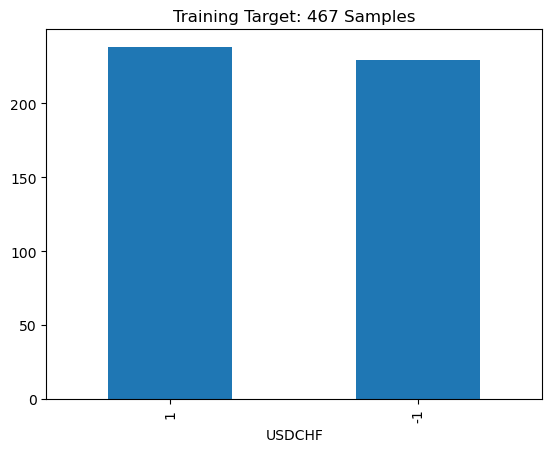

In [37]:
y_train.value_counts().plot(kind='bar',title='Training Target: 467 Samples')


In [38]:
y_train.value_counts()

USDCHF
 1    238
-1    229
Name: count, dtype: int64

(312, 7)

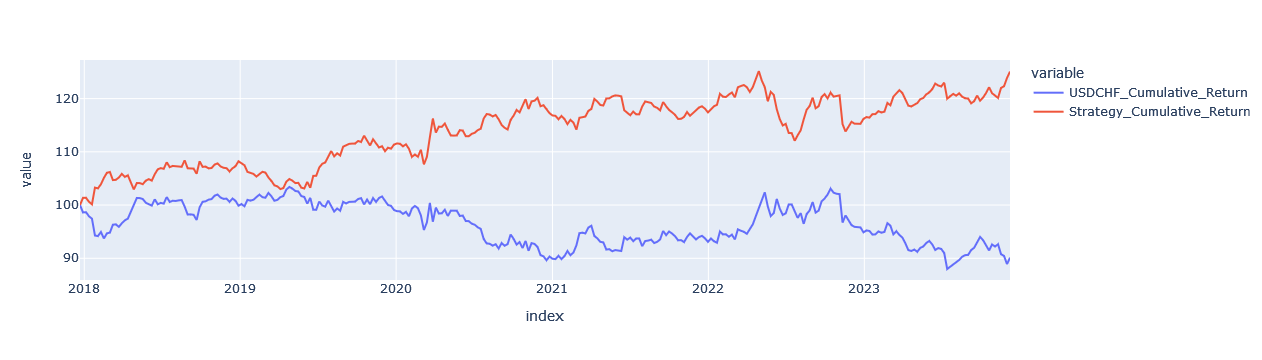

In [53]:
# Create a new DataFrame 'Strategy' containing the 'USDJPY' values from the test set, shifted by one position to represent the next date
Strategy = pd.DataFrame(df_combined['USDCHF'][x_train.shape[0]+1:])

# Add the 'Y_pred' (predictions) from the random forest model as a new column 'Prediction' in the 'Strategy' DataFrame
Strategy['Prediction'] = y_pred

# Drop any rows with missing values (NaN) in the 'Strategy' DataFrame
Strategy.dropna(inplace=True)

# Calculate the 'Strategy' column, which represents the strategy's performance based on multiplying 'USDJPY' with 'Prediction'
transaction_cost =  0.00015 #4 Bps Transaction Cost

Strategy['Transaction_Cost'] = abs(Strategy['Prediction'] - Strategy['Prediction'].shift(1)) * transaction_cost # Calculate transaction cost
Strategy['Strategy'] = (Strategy['Prediction'] * Strategy['USDCHF']) - Strategy['Transaction_Cost']  # Adjusted return

Strategy.dropna(inplace=True)

# Calculate the cumulative return for 'USDJPY' and 'Strategy' by taking the cumulative sum and multiplying by 100, then adding 100 to start from the initial value of 100
Strategy['USDCHF_Cumulative_Return'] = (Strategy['USDCHF'].cumsum() * 100).add(100)
Strategy['Strategy_Cumulative_Return'] = (Strategy['Strategy'].cumsum() * 100).add(100)

# Create a dictionary 'new_row' representing a new row of data with zeros for 'USDJPY', 'Prediction', 'Strategy' and 100 for 'USDJPY_Cumulative_Return' and 'Strategy_Cumulative_Return'
new_row = {'USDCHF': 0.0, 'Prediction': 0.0, 'Strategy': 0.0, 'USDCHF_Cumulative_Return': 100.0, 'Strategy_Cumulative_Return': 100.0}

# Create a DataFrame 'new_row_df' from the 'new_row' dictionary and set the index to '2021-01-01'
new_row_df = pd.DataFrame(new_row, index=[Strategy.index[0] - timedelta(days=7)])

# Concatenate the 'new_row_df' DataFrame with the 'Strategy' DataFrame to add the new row at the beginning
Strategy = pd.concat([new_row_df, Strategy])

# Plot a line chart showing the 'USDJPY_Cumulative_Return' and 'Strategy_Cumulative_Return' columns from the 'Strategy' DataFrame
px.line(Strategy[['USDCHF_Cumulative_Return', 'Strategy_Cumulative_Return']])



In [54]:
# Calculate portfolio returns
eurusd_returns = Strategy['USDCHF']
strategy_returns = Strategy['Strategy']

# Calculate portfolio annualized return
eurusd_annual_return = eurusd_returns.mean() * 52
strategy_annual_return = strategy_returns.mean() * 52

# Calculate portfolio volatility
eurusd_volatility = eurusd_returns.std() * np.sqrt(52)
strategy_volatility = strategy_returns.std() * np.sqrt(52)

# Calculate portfolio cumulative returns
eurusd_cumulative_returns = eurusd_returns.cumsum().iloc[-1]
strategy_cumulative_returns = strategy_returns.cumsum().iloc[-1]

# Calculate portfolio Information Ratio
eurusd_sharpe_ratio = eurusd_annual_return / eurusd_volatility
strategy_sharpe_ratio = strategy_annual_return / strategy_volatility

# Calculate portfolio maximum drawdown
eurusd_drawdown = np.min(Strategy['USDCHF_Cumulative_Return'] / Strategy['USDCHF_Cumulative_Return'].cummax() - 1)
strategy_drawdown = np.min(Strategy['Strategy_Cumulative_Return'] / Strategy['Strategy_Cumulative_Return'].cummax() - 1)

# Print the comparison metrics
print("Portfolio Comparison Metrics:")
print(f"{'-' * 30}")
print(f"{'Metric':<25}{'USDCHF':<25}{'Strategy':<25}")
print(f"{'-' * 30}")
print(f"Cumulative Return:        {eurusd_cumulative_returns:<25.4f}{strategy_cumulative_returns:<25.4f}")
print(f"Annualized Return:        {eurusd_annual_return:<25.4f}{strategy_annual_return:<25.4f}")
print(f"Annualized Volatility:    {eurusd_volatility:<25.4f}{strategy_volatility:<25.4f}")
print(f"Sharpe Ratio:             {eurusd_sharpe_ratio:<25.4f}{strategy_sharpe_ratio:<25.4f}")
print(f"Maximum Drawdown:         {eurusd_drawdown:<25.4f}{strategy_drawdown:<25.4f}")
print(f"{'-' * 30}")


Portfolio Comparison Metrics:
------------------------------
Metric                   USDCHF                   Strategy                 
------------------------------
Cumulative Return:        -0.0988                  0.2508                   
Annualized Return:        -0.0165                  0.0418                   
Annualized Volatility:    0.0754                   0.0751                   
Sharpe Ratio:             -0.2186                  0.5564                   
Maximum Drawdown:         -0.1491                  -0.1049                  
------------------------------


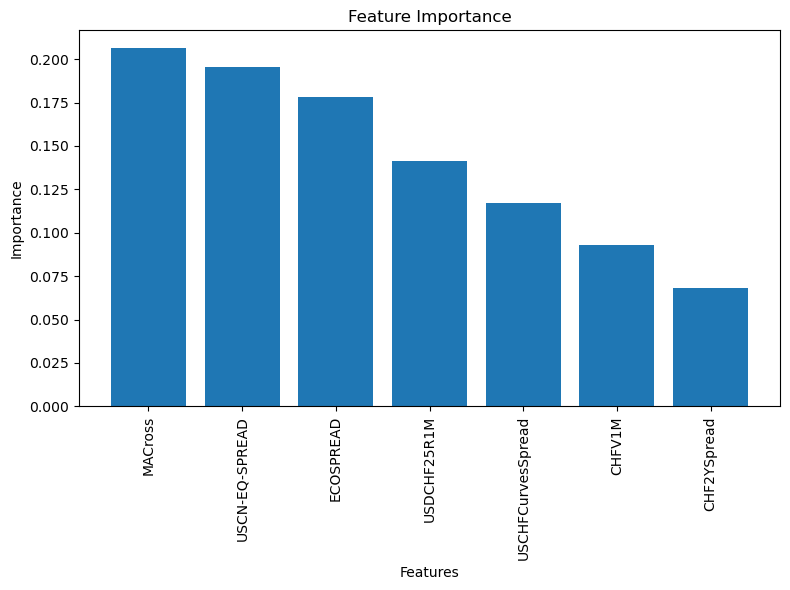

In [55]:
# Get the feature importances
importances = model.feature_importances_

# Get the names of the features
feature_names = x_train.columns

# Create a dataframe to store the feature importances
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})

# Sort the dataframe by importance (descending order)
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Plot the feature importances
plt.figure(figsize=(8, 6))
plt.bar(importance_df['Feature'], importance_df['Importance'])
plt.xticks(rotation=90)
plt.xlabel('Features')
plt.ylabel('Importance')
plt.title('Feature Importance')
plt.tight_layout()
plt.show()

C:\ProgramData\anaconda3\Lib\site-packages\sklearn\model_selection\_split.py:725: UserWarning:

The least populated class in y has only 3 members, which is less than n_splits=5.



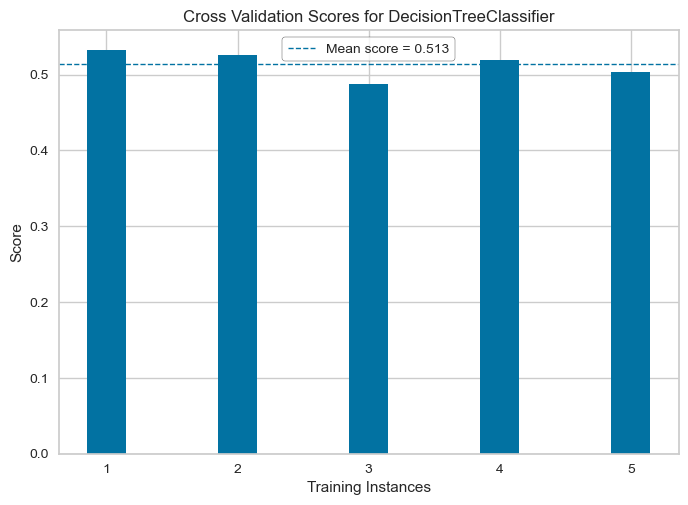

<Axes: title={'center': 'Cross Validation Scores for DecisionTreeClassifier'}, xlabel='Training Instances', ylabel='Score'>

In [57]:
from sklearn.model_selection import StratifiedKFold
from yellowbrick.model_selection import CVScores
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
visualizer = CVScores(model, cv=cv, scoring='accuracy')
visualizer.fit(x, y)        # Fit the data to the visualizer
visualizer.show()  

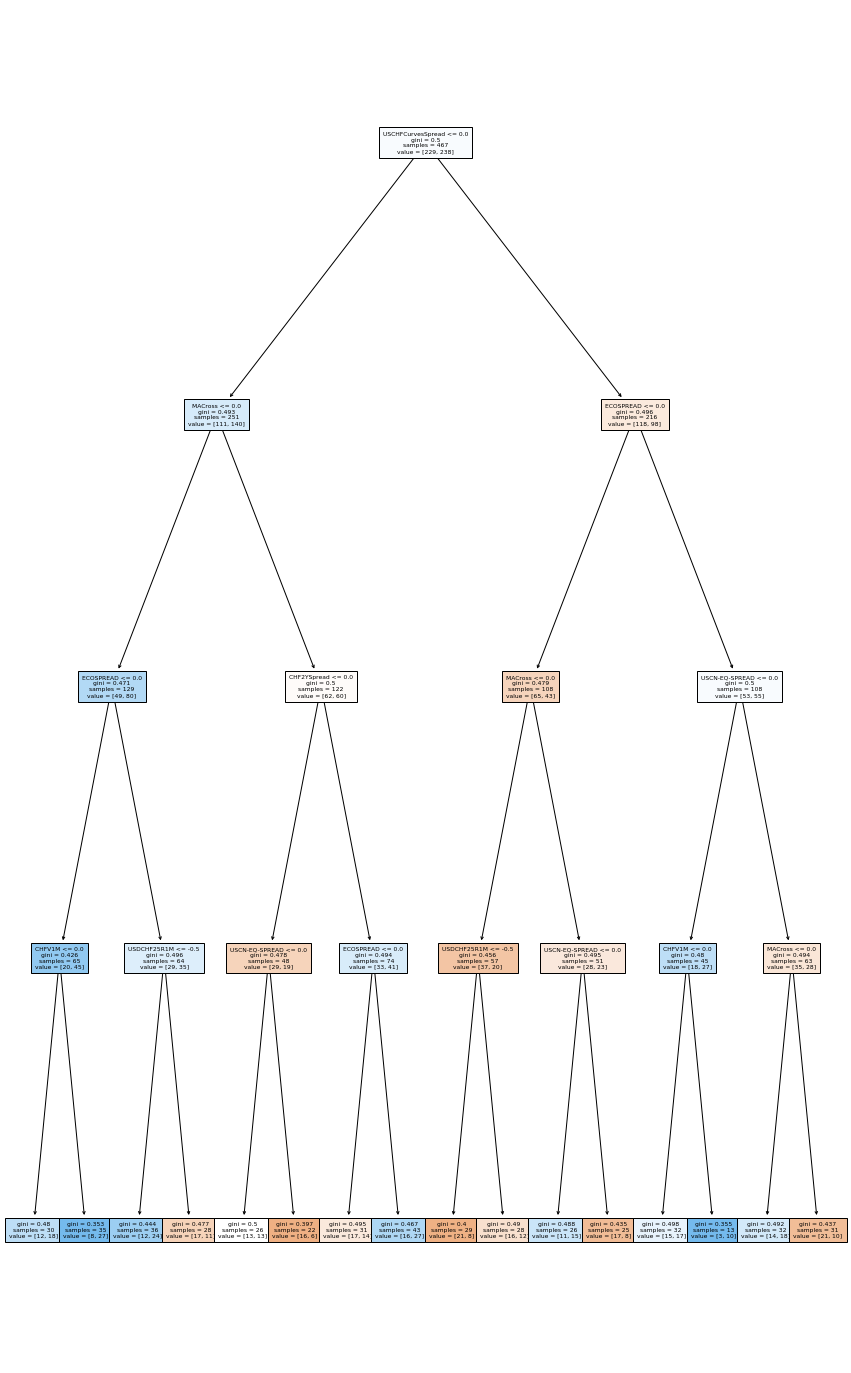

In [19]:
from sklearn import tree
from matplotlib import pyplot as plt
fig, axes = plt.subplots(figsize = (15,25))
tree.plot_tree(model, feature_names=x_train.columns.tolist(),filled=True,fontsize=6)
plt.show()

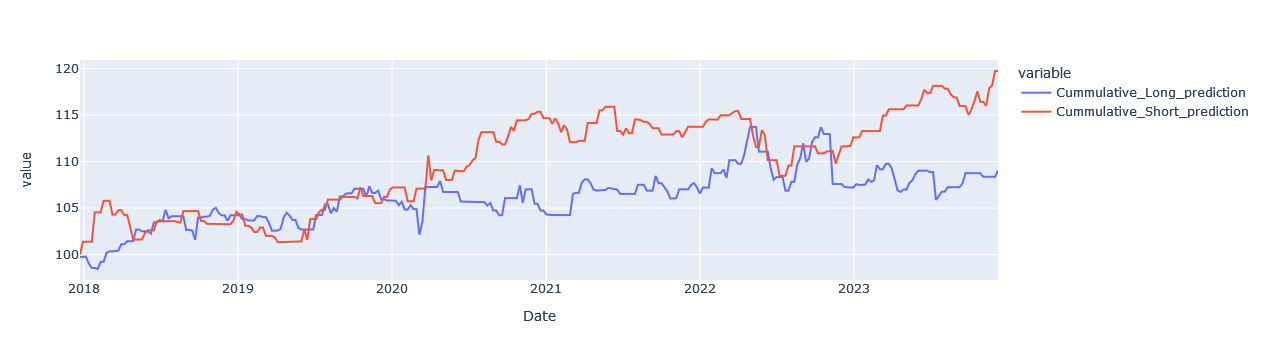

In [20]:
Performance_Contribution = pd.DataFrame(df_combined['USDCHF'][x_train.shape[0]+1:])

# Add the 'Y_pred' (predictions) from the random forest model as a new column 'Prediction' in the 'Strategy' DataFrame
Performance_Contribution['Prediction'] = y_pred

Performance_Contribution['Short_prediction'] = np.where(Performance_Contribution['Prediction'] < 0, Performance_Contribution['USDCHF'] * Performance_Contribution['Prediction'], 0)

Performance_Contribution['Long_prediction'] = np.where(Performance_Contribution['Prediction'] >= 0, Performance_Contribution['USDCHF'] * Performance_Contribution['Prediction'], 0)

Performance_Contribution['Cummulative_Short_prediction'] = (Performance_Contribution['Short_prediction'].cumsum() * 100).add(100)

Performance_Contribution['Cummulative_Long_prediction'] = (Performance_Contribution['Long_prediction'].cumsum() * 100).add(100)

px.line(Performance_Contribution[['Cummulative_Long_prediction', 'Cummulative_Short_prediction']])

In [21]:
Performance_Contribution

,USDCHF,Prediction,Short_prediction,Long_prediction,Cummulative_Short_prediction,Cummulative_Long_prediction
Date,,,,,,
2017-12-22,-0.002524,1,0.000000,-0.002524,100.000000,99.747602
2017-12-29,-0.013866,-1,0.013866,0.000000,101.386640,99.747602
2018-01-05,0.000411,1,0.000000,0.000411,101.386640,99.788657
2018-01-12,-0.007592,1,0.000000,-0.007592,101.386640,99.029449
2018-01-19,-0.004652,1,0.000000,-0.004652,101.386640,98.564237
...,...,...,...,...,...,...
2023-11-10,0.004339,-1,-0.004339,0.000000,115.978979,108.364998
2023-11-17,-0.018832,-1,0.018832,0.000000,117.862218,108.364998
2023-11-24,-0.003048,-1,0.003048,0.000000,118.167062,108.364998


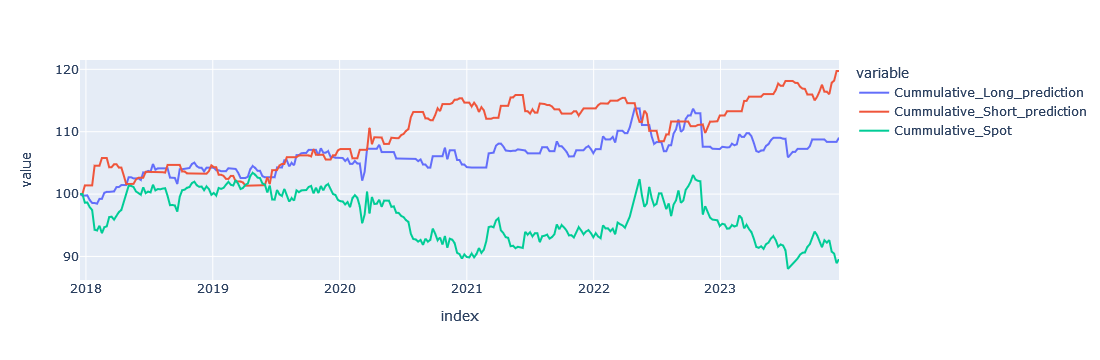

In [22]:
Performance_Contribution = pd.DataFrame(df_combined['USDCHF'][-len(y_pred):])
 
# Add the 'Y_pred' (predictions) from the random forest model as a new column 'Prediction' in the 'Strategy' DataFrame
Performance_Contribution['Prediction'] = y_pred
 
Performance_Contribution['Short_prediction'] = np.where(Performance_Contribution['Prediction'] < 0, Performance_Contribution['USDCHF'] * Performance_Contribution['Prediction'], 0)
 
Performance_Contribution['Long_prediction'] = np.where(Performance_Contribution['Prediction'] >= 0, Performance_Contribution['USDCHF'] * Performance_Contribution['Prediction'], 0)
 
Performance_Contribution['Cummulative_Short_prediction'] = (Performance_Contribution['Short_prediction'].cumsum() * 100).add(100)
 
Performance_Contribution['Cummulative_Long_prediction'] = (Performance_Contribution['Long_prediction'].cumsum() * 100).add(100)
 
Performance_Contribution['Cummulative_Spot'] = (Strategy['USDCHF'].cumsum() * 100).add(100)
 
fist_row = {'USDCHF': 0.0,'Cummulative_Short_prediction': 100.0, 'Cummulative_Spot': 100.0, 'Cummulative_Long_prediction': 100.0}
 
fist_row_df = pd.DataFrame(fist_row, index=[Performance_Contribution.index[0] - timedelta(days=7)])
 
Performance_Contribution = pd.concat([Performance_Contribution,fist_row_df]).sort_index()
 
px.line(Performance_Contribution[['Cummulative_Long_prediction', 'Cummulative_Short_prediction','Cummulative_Spot']])

In [30]:
Performance_Contribution

,USDCHF,Prediction,Short_prediction,Long_prediction,Cummulative_Short_prediction,Cummulative_Long_prediction,Cummulative_Spot
2017-12-15,0.000000,NaN,NaN,NaN,100.000000,100.000000,100.000000
2017-12-22,-0.002524,1.0,0.000000,-0.002524,100.000000,99.747602,100.000000
2017-12-29,-0.013866,-1.0,0.013866,0.000000,101.386640,99.747602,98.613360
2018-01-05,0.000411,1.0,0.000000,0.000411,101.386640,99.788657,98.654415
2018-01-12,-0.007592,1.0,0.000000,-0.007592,101.386640,99.029449,97.895207
...,...,...,...,...,...,...,...
2023-11-10,0.004339,-1.0,-0.004339,0.000000,115.978979,108.364998,92.638417
2023-11-17,-0.018832,-1.0,0.018832,0.000000,117.862218,108.364998,90.755178
2023-11-24,-0.003048,-1.0,0.003048,0.000000,118.167062,108.364998,90.450334
2023-12-01,-0.015629,-1.0,0.015629,0.000000,119.729916,108.364998,88.887480


In [31]:
input_data = df_binary.loc['2023-12-08'].drop('USDCHF').values

# Reshape the input data to a 2D array
input_data_2d = np.reshape(input_data, (1, -1))

# Make predictions using the reshaped data
predictions = model.predict(input_data_2d)

# Print or use the predictions as needed
print(predictions)

[-1]


c:\Users\shandar\Anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning:

X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names



In [66]:
x=model.apply(x_train)

array([20, 26, 15, 30, 26, 23, 15,  5, 19,  4, 15,  5, 29, 26,  8, 22, 19,
       19,  5, 20, 19,  5,  8, 19, 19, 12, 22, 11, 30, 19,  4, 30, 11,  8,
       11, 20,  5, 29,  8, 20, 29,  7, 26, 22, 20, 15, 30,  8, 26, 30, 22,
       30, 15, 29,  4, 11, 15, 30, 22, 14, 11, 23,  7, 29, 20, 19, 23, 11,
       15, 11, 14, 26, 15, 26, 22, 23, 19,  5,  7, 29,  5, 20,  8,  7,  5,
       29,  7, 29,  8, 20,  7,  4,  5, 20,  5, 23, 15, 26, 26, 14, 23, 30,
        8, 19,  7, 29, 12, 26, 22, 29, 15, 30, 12, 29,  5,  5, 22, 15, 19,
       12, 19,  5,  5, 26, 12, 14,  4, 29,  8,  7, 30, 12, 19, 29,  7,  7,
        5,  4, 30, 15, 11, 30, 14, 26, 26, 30,  8, 29,  5, 30, 15, 14, 30,
       27, 11, 23, 11, 12, 12, 19,  5,  7,  4, 20,  4, 20,  4, 19, 14, 20,
        5, 26,  4, 20,  8,  8, 15, 15, 14, 30, 14, 26,  4, 15, 15, 22, 14,
        8, 29, 29,  8,  8, 26, 29,  8,  5, 26, 15, 26, 29, 11, 15, 12, 19,
        4, 27,  7,  8,  5, 20,  5, 22, 23, 19, 15, 26, 11, 11, 30, 15, 15,
       14,  4, 29,  5,  4

In [ ]:
# I am adding this code for fun, just checking the github
# this is only the change for branch justinxu, checking please